<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/TestSelectionWindowEffect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

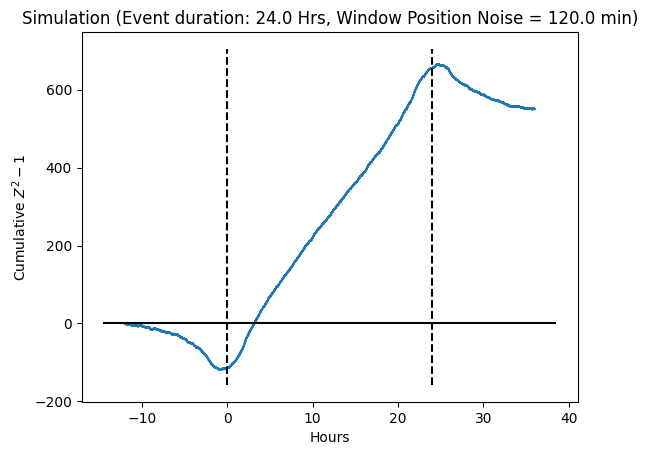

In [59]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

timeseries_len = 60*60*24*10 #simulate 10 days worth of data
selection_window_len = 60*60*24
flank_len = int(selection_window_len/2)
num_to_sim = 1000
varscale = 1.00 #to explore what happens if we increase the RNG var slightly
window_jitter_max = 60*60*2 #2 hrs

def simulate_rng_sample(rng, length): #returns chi-square-minus-1
  return np.square(rng.normal(size=(length,), scale=varscale))-1

all_expanded_windows_cumsum = []
rng = np.random.RandomState()
for i in range(num_to_sim):
  simulated_series = simulate_rng_sample(rng, length=timeseries_len)
  #find the window with the maximum conflips
  #first compute the cumulative sum
  cumsum_simulated_series = np.cumsum(simulated_series)
  #compute sums within sliding windows
  windowsums = (cumsum_simulated_series[selection_window_len:]
                - cumsum_simulated_series[:-selection_window_len])
  #find index of maximum sliding window, simulating selection
  argmax_window_idx = np.argmax(windowsums)
  #map argmax_window_idx to the start and end of the window in simulated_series
  argmax_window_start = argmax_window_idx+1
  argmax_window_end = argmax_window_start+selection_window_len
  #sanity check indexing
  assert np.abs(windowsums[argmax_window_idx]
          -np.sum(simulated_series[argmax_window_start:argmax_window_end])) < 1e-6
  #Add jitter to simulate imperfect selection:
  windowshift = int(rng.uniform(window_jitter_max*2))-window_jitter_max
  argmax_window_start += windowshift
  argmax_window_end += windowshift

  #We will take a window of +/- flank_len centered on the selection window
  expanded_window_start = argmax_window_start-flank_len
  expanded_window_end = argmax_window_end+flank_len
  #if the expanded window start/end goes over the edge of the simulated
  # sequence, skip it
  if (expanded_window_start < 0 or expanded_window_end > len(simulated_series)):
    continue
  all_expanded_windows_cumsum.append(
      np.cumsum(simulated_series[expanded_window_start:expanded_window_end]))

mean_expanded_windows_cumsum = np.mean(all_expanded_windows_cumsum, axis=0)
plt.plot(np.arange(len(mean_expanded_windows_cumsum))/(60*60) - flank_len/(60*60), mean_expanded_windows_cumsum)
plt.plot(plt.xlim(), [0,0], color="black")
#plot dashed lines around the selected window
ylim = plt.ylim()
plt.plot([0, 0], ylim, color="black", linestyle="--")
plt.plot([selection_window_len/(60*60), selection_window_len/(60*60)], ylim, color="black", linestyle="--")
plt.xlabel("Hours")
plt.ylabel("Cumulative $Z^2 - 1$")
plt.title("Simulation (Event duration: "+str(selection_window_len/(60*60))+" Hrs, Window Position Noise = "+str(window_jitter_max/60)+" min)")
plt.show()

In [61]:
print(len(all_expanded_windows_cumsum)) #number of trials where expanded window didn't go over the edge

866
